In [3]:
import spacy
import pandas as pd

In [4]:
df=pd.read_csv('./Merged_all_states_data.csv')

In [5]:
df.shape

(5432, 6)

In [6]:
df.head()

,Unnamed: 0,title,headline,detail_id,new_link,Case Details
0,0,Icici Lombardf General Insurance Co Ltd vs Mon...,"thus,\nhelped him in getting acquittal. \n...",/docfragment/78128413/?formInput=insurance%20f...,https://indiankanoon.org/docfragment/78128413//,Take notes as you read a judgment using our V...
1,1,Moni Devi And Ors vs Hemant Bhardwaj And Anr o...,"thus,\nhelped him in getting acquittal. \n...",/docfragment/19875390/?formInput=insurance%20f...,https://indiankanoon.org/docfragment/19875390//,Take notes as you read a judgment using our V...
2,2,"Arman vs State Of Haryana on 27 August, 2024",attention towards the i...,/docfragment/189088157/?formInput=insurance%20...,https://indiankanoon.org/docfragment/189088157//,Take notes as you read a judgment using our V...
3,3,Dashrath Tanwar vs Life Insurance Corporation ...,extracted from\n\nCWP-12070-2018 titled as...,/docfragment/52555161/?formInput=insurance%20f...,https://indiankanoon.org/docfragment/52555161//,Take notes as you read a judgment using our V...
4,4,Kailash Kumar Shoree vs Ut Chandigarh on 14 Au...,forging the signatures of Late Smt.\n ...,/docfragment/139103740/?formInput=insurance%20...,https://indiankanoon.org/docfragment/139103740//,Take notes as you read a judgment using our V...


In [7]:
nlp=spacy.load("en_core_web_sm")
nlp.max_length=2000000

In [8]:
def preprocess(text):
    doc=nlp(text)
    li=[]
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        else:
         li.append(token.lemma_)
    return " ".join(li)

In [9]:
from tqdm import tqdm

In [10]:
tqdm.pandas()

In [11]:
df["new_text"]=df["Case Details"].progress_apply(preprocess)

100%|██████████| 5432/5432 [1:18:31<00:00,  1.15it/s]  


In [12]:
def word_embedding(text):
    doc=nlp(text)
    return doc.vector

In [13]:
df["text_word_embedded"]=df["new_text"].progress_apply(word_embedding)

  0%|          | 0/5432 [00:00<?, ?it/s]

100%|██████████| 5432/5432 [1:22:49<00:00,  1.09it/s]     


In [21]:
df.to_csv('./word_embeddings_all_states.csv')

In [11]:
import pandas as pd
df = pd.read_csv('./word_embeddings_all_states.csv')
df = df[df["Case Details"] != "Failed to retrieve case details."].reset_index(drop=True)

In [17]:
import numpy as np
df["text_word_embedded"] = df["text_word_embedded"].apply(lambda x: np.fromstring(x.replace("\n", "")[1:-1], dtype=float, sep=' ')) #if type(x) == 'str' else x) 


d:\Programs\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Scores for Clustering Models:
KMeans: 0.2947
DBSCAN: -0.3015
Agglomerative: 0.2758
SpectralClustering: 0.6787
GaussianMixture: 0.0929
MeanShift: 0.2534

Support for each cluster:
ensemble_cluster
0.0    0.946989
1.0    0.053011
Name: count, dtype: float64

Confidence for each cluster:
ensemble_cluster
0.0    0.946989
1.0    0.053011
Name: count, dtype: float64

Cluster Distribution:
ensemble_cluster
0.0    5127
1.0     287
Name: count, dtype: int64


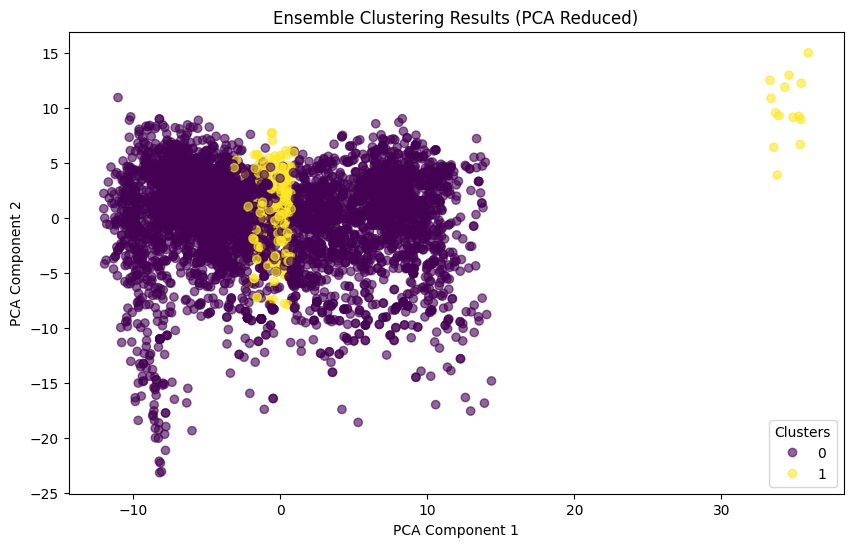


Final Potential Fraudulent Cases (54):
                                           Case Details  ensemble_cluster  \
2166  Take notes as you read a judgment using our  V...               0.0   
2937  Take notes as you read a judgment using our  V...               0.0   
2964  Take notes as you read a judgment using our  V...               0.0   
2974  Take notes as you read a judgment using our  V...               0.0   
2976  Take notes as you read a judgment using our  V...               0.0   
2978  Take notes as you read a judgment using our  V...               0.0   
3001  Take notes as you read a judgment using our  V...               0.0   
3012  Take notes as you read a judgment using our  V...               0.0   
3149  Take notes as you read a judgment using our  V...               0.0   
3174  Take notes as you read a judgment using our  V...               0.0   
3895  Take notes as you read a judgment using our  V...               0.0   
4018  Take notes as you read a judgm

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'text_word_embedded' is your word embedding matrix
# text_word_embedded = ...  # Load or define your word embeddings here
X = np.array(list(df['text_word_embedded']))
# 1. Data Scaling and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA with 50 components (adjustable)
pca = PCA(n_components=50)  
X_pca = pca.fit_transform(X_scaled)

# 2. Clustering Models
clustering_models = {
    'KMeans': KMeans(n_clusters=2, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative': AgglomerativeClustering(n_clusters=2),
    'SpectralClustering': SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42),
    'GaussianMixture': GaussianMixture(n_components=2, random_state=42),
    'MeanShift': MeanShift()
}

# 3. Fit Models and Collect Cluster Labels
cluster_labels = pd.DataFrame()

for name, model in clustering_models.items():
    if name == 'DBSCAN':
        model.fit(X_scaled)
        labels = model.labels_
    else:
        labels = model.fit_predict(X_scaled)
    cluster_labels[name] = labels

import pandas as pd

# 4. Handle Different Number of Clusters (for DBSCAN noise points)
for name in cluster_labels.columns:
    if name == 'DBSCAN':
        max_label = cluster_labels[name].max()
        cluster_labels[name] = cluster_labels[name].apply(lambda x: x if x != -1 else max_label + 1)

# 5. Ensemble Clustering via Majority Voting
ensemble_labels = cluster_labels.mode(axis=1)[0]
df['ensemble_cluster'] = ensemble_labels

# 6. Evaluate Clustering Quality (Silhouette Score)
sil_scores = {}
for name in clustering_models.keys():
    if name == 'DBSCAN' and -1 in cluster_labels[name].unique():
        if len(set(cluster_labels[name])) > 1:
            sil = silhouette_score(X_scaled, cluster_labels[name])
            sil_scores[name] = sil
    else:
        sil = silhouette_score(X_scaled, cluster_labels[name])
        sil_scores[name] = sil

print("Silhouette Scores for Clustering Models:")
for name, score in sil_scores.items():
    print(f"{name}: {score:.4f}")

# Identify the best model based on silhouette score
best_model_name = max(sil_scores, key=sil_scores.get)
best_sil_score = sil_scores[best_model_name]

# 7. Calculate Support and Confidence
# Support = Proportion of data points in each cluster
# Confidence = Ratio of points in the cluster to total points

cluster_counts = df['ensemble_cluster'].value_counts()
support = cluster_counts / len(df)
confidence = cluster_counts / cluster_counts.sum()

print("\nSupport for each cluster:")
print(support)

print("\nConfidence for each cluster:")
print(confidence)

# 8. Visualize Cluster Distribution
print("\nCluster Distribution:")
print(df['ensemble_cluster'].value_counts())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['ensemble_cluster'], cmap='viridis', alpha=0.6)
plt.title('Ensemble Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# 9. Identify Potential Fraudulent Clusters
threshold = 20  # Define a threshold for small clusters
fraud_clusters = cluster_counts[cluster_counts < threshold].index.tolist()
df['is_potential_fraud'] = df['ensemble_cluster'].apply(lambda x: 1 if x in fraud_clusters else 0)

# 10. Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X_scaled)
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Combine Cluster-Based and Anomaly Detection Results
df['final_fraud_flag'] = df['is_potential_fraud'] | df['is_anomaly']

# Final Fraud Cases
final_frauds = df[df['final_fraud_flag'] == 1]
print(f"\nFinal Potential Fraudulent Cases ({len(final_frauds)}):")
print(final_frauds[['Case Details', 'ensemble_cluster', 'is_anomaly']])

# 11. Print and Save Best Model
print(f"THE BEST MODEL IS: {best_model_name} WITH SILHOUETTE SCORE: {best_sil_score:.4f}".upper())


# Save the best model's results
# df['best_model_cluster'] = cluster_labels[best_model_name]
# df.to_csv(f"best_model_{best_model_name}_results.csv", index=False)
# print(f"Results saved as 'best_model_{best_model_name}_results.csv'")

In [20]:
clustering_models['SpectralClustering']

SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=42)

In [ ]:
import joblib

with open('./model', 'wb') as f:
    joblib.dump(clustering_models['SpectralClustering'], f)


with open('./scaler', 'wb') as f:
    joblib.dump(scaler, f)

with open('./Xscaled', 'wb') as f:
    joblib.dump(X_scaled, f)